## Word Attributions via Layer Integrated Gradients (in progress)
- implemented through Transformers Interpret Link: https://github.com/cdpierse/transformers-interpret#sequence-classification-explainer
''Captum has a variety of attributions methods, the default in transformers interpret is *Layer Integrated Gradients*, with the attribution scores effectively being a summary or average of each layers’ attributions''
- built on Captum library Link: https://captum.ai/docs/algorithms
- original paper integreted gradients Link: https://arxiv.org/pdf/1703.01365.pdf Axiomatic Attribution for Deep Networks

DONE:

- I have used transformers interpret to explain Multilingual Bert and XLM predictions 
- used for mBERT test_bias e test_no_bias
- I have tried by cleaning explanations from punctuation, stop words and ##


TO DO:

- Understand how to deal with ## 
- XLM test_bias e no_bias 
- do with punctuation
- analyze explanations (through graph with extension '_all.csv')
Compute model explanations (complete code at explain_test.py)

In [1]:
!pip install transformers_interpret
!pip install SentencePiece 

In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch
from sklearn.metrics import f1_score
import pickle
from collections import Counter
from transformers import logging
logging.set_verbosity_error()
import json
import csv

2022-01-09 18:02:39.131936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 18:02:39.147824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_word_attributions(model, tokenizer, data):
    '''
    given as input the pretrained model, the tokenizer and a set of text data, this function make explanations for each articles and outputs 
    a dict with as key the predicted class and as value - for each article belonging to that class- a list of tuple(word, word_attribution) saying how much that word 
    has contributed to the predicted class.

    'model': pretrained model,
    'tokenizer': pretrained tokenizer,
    'data': dataframe of texts to be explained
    '''

    # model classes
    #print('Classes:', model.config.id2label)
    
    multiclass_explainer = SequenceClassificationExplainer(
        model,
        tokenizer)
        
    # list of articles to explain
    texts = data.short_maintext.to_list()
    src = data.source_name.to_list()
    #src_names = list(set(data.source_name.to_list()))
    real_class = data.political_leaning.to_list()
    mapping = {'LABEL_1':'Liberal','LABEL_0':'Conservative', 'LABEL_2':'Centre-left', 'LABEL_4':'Left-wing', 'LABEL_3':'Liberal-conservative','LABEL_5':'Right-wing'}
    # mapping src_name:political_label
    with open(r'/homenfs/l.bellomo1/datasets/new_attempt_classifier/explainability/mappings/media_label.json', encoding='utf-8') as fp:
        media_label = json.loads(fp.read())
    src_names = list(media_label.keys())
    corrected_pred = 0
    '''
    Compute explanations
    '''
    # dict to store class-explanations
    class_explained = dict() 

    # for each article in the test set compute the explanation and then putting it into a list res
    for i in range(len(texts)): 
        # select only the first 512 tokens as in the training set
        text = texts[i][:512] 
        
        # word attributions for each article
      
        word_attributions = multiclass_explainer(text)
        print('source name:', src[i])
        print('real class:', real_class[i])
        print('predicted class:', mapping[multiclass_explainer.predicted_class_name])
        if real_class[i] == mapping[multiclass_explainer.predicted_class_name]:
            corrected_pred +=1
        print(corrected_pred)
        
        '''for media in src_names:
            if media.lower() in text.lower():
                print('Cited media:',media,'Media leaning:',media_label[media])'''
        multiclass_explainer.visualize()
        '''
        # storing class-explanations in each class dict
        if multiclass_explainer.predicted_class_name == 'LABEL_0':
            if 'conservative' not in class_explained:
                class_explained['conservative'] = list()
            class_explained['conservative'].append(word_attributions)
        elif multiclass_explainer.predicted_class_name == 'LABEL_1':
            if 'liberal' not in class_explained:
                class_explained['liberal'] = list()
            class_explained['liberal'].append(word_attributions)
        elif multiclass_explainer.predicted_class_name == 'LABEL_2':
            if 'centre_left' not in class_explained:
                class_explained['centre_left'] = list()
            class_explained['centre_left'].append(word_attributions)  
        elif multiclass_explainer.predicted_class_name == 'LABEL_3':
            if 'liberal_conservative' not in class_explained:
                class_explained['liberal_conservative'] = list()
            class_explained['liberal_conservative'].append(word_attributions)  
        elif multiclass_explainer.predicted_class_name == 'LABEL_4':
            if 'left' not in class_explained:
                class_explained['left'] = list()
            class_explained['left'].append(word_attributions)  
        elif multiclass_explainer.predicted_class_name == 'LABEL_5':
            if 'right' not in class_explained:
                class_explained['right'] = list()
            class_explained['right'].append(word_attributions)  
     '''
    print('accuracy', corrected_pred/len(texts))
    # saving explanations
    '''with open(path_to, 'wb') as handle:
        pickle.dump(class_explained, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

#### XLM example 

In [4]:
'''
get_word_attributions() Input
'''

# model
model_path = r'C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\models\XLM\no_punt\finetuned_XLM_epoch_3.model'
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.load_state_dict(torch.load(model_path))
# tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', 
                                          do_lower_case=False)
# data to explain
data = pd.read_csv(r"C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\data_to_explain\test_bias_nopunt_sample1000.csv")
data = data.groupby('political_leaning').apply(lambda x: x.sample(n=4)) # select only a sample for computational reasons

get_word_attributions(model, tokenizer, data)

Classes: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5'}
LABEL_0


LABEL_0


LABEL_0


LABEL_2


LABEL_0


LABEL_0


LABEL_0


LABEL_0


LABEL_4


LABEL_4


LABEL_3


LABEL_4


LABEL_1


LABEL_1


LABEL_1


LABEL_4


LABEL_0


LABEL_1


LABEL_2


LABEL_0


LABEL_5


LABEL_5


LABEL_5


LABEL_5


DONE!


#### mBERT example

In [6]:
'''
get_word_attributions() Input
'''

# model
model_path = r'C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\models\MultiBert_6class_all\punt\finetuned_MBERT6class_epoch_3_new.model'
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load(model_path))
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          do_lower_case=False) 
# data to explain
data = pd.read_csv(r"C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\data_to_explain\test_bias_punt_sample1000.csv")
data = data.groupby('political_leaning').apply(lambda x: x.sample(n=4)) # select only a sample for computational reasons

get_word_attributions(model, tokenizer, data)

Classes: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5'}
LABEL_0


LABEL_2


LABEL_2


LABEL_2


LABEL_0


LABEL_0


LABEL_0


LABEL_0


LABEL_4


LABEL_0


LABEL_4


LABEL_2


LABEL_1


LABEL_1


LABEL_1


LABEL_1


LABEL_1


LABEL_3


LABEL_3


In [3]:
pd.set_option('max_colwidth', 800)

### Assessing media name impact on predictions (via IG word attributions)

In [4]:
pd.set_option('max_colwidth', 800)

In [5]:
import pandas as pd
test_bias_punt = pd.read_csv(r'/homenfs/l.bellomo1/datasets/new_attempt_classifier/explainability/data_to_explain/test_bias_cleaned.csv')
# shortening the legth of sequence as for bert tokenizer
test_bias_punt['short_maintext'] = test_bias_punt['maintext'].str.slice(0,600)
len(test_bias_punt)

45000

#### mBERT: searching all media that cited theirself in maiuscolo
- attempt done searching all media that cited theirself in maiuscolo
- TODO: prova rimuovendo la testata

In [6]:
'''
get_word_attributions() Input
'''

# model
model_path = r'C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\models\MultiBert_6class_all\punt\finetuned_MBERT6class_epoch_3_new.model'
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load(model_path))
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          do_lower_case=False)

# data to explain: picking all media that cite theirself in upper characters inside the article
# src_names contained in test biased
src_names = list(test_bias_punt.source_name.unique())
src_names = [elem.upper() for elem in src_names]
test_contains = test_bias_punt[test_bias_punt.short_maintext.str.contains('|'.join(src_names),case=True)]
print(len(test_contains))

get_word_attributions(model, tokenizer, test_contains)

C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


35
source name: Le Monde
real class: Centre-left
predicted class: Centre-left
1


source name: Demokraatti
real class: Centre-left
predicted class: Centre-left
2


source name: Demokraatti
real class: Centre-left
predicted class: Centre-left
3


source name: Le Monde
real class: Centre-left
predicted class: Centre-left
4


source name: Spiegel Online
real class: Centre-left
predicted class: Centre-left
5


source name: Le Monde
real class: Centre-left
predicted class: Centre-left
6


source name: Demokraatti
real class: Centre-left
predicted class: Centre-left
7


source name: Aftonbladet
real class: Centre-left
predicted class: Centre-left
8


source name: Le Monde
real class: Centre-left
predicted class: Centre-left
9


source name: El País
real class: Centre-left
predicted class: Centre-left
10


source name: Bild
real class: Conservative
predicted class: Conservative
11


source name: Bild
real class: Conservative
predicted class: Conservative
12


source name: Bild
real class: Conservative
predicted class: Conservative
13


source name: Bild
real class: Conservative
predicted class: Conservative
14


source name: El Mundo
real class: Conservative
predicted class: Conservative
15


source name: El Mundo
real class: Conservative
predicted class: Conservative
16


source name: Bild
real class: Conservative
predicted class: Conservative
17


source name: Bild
real class: Conservative
predicted class: Conservative
18


source name: Bild
real class: Conservative
predicted class: Conservative
19


source name: Bild
real class: Conservative
predicted class: Conservative
20


source name: The Times
real class: Conservative
predicted class: Conservative
21


source name: Welt am Sonntag
real class: Conservative
predicted class: Conservative
22


source name: Bild
real class: Conservative
predicted class: Conservative
23


source name: Bild
real class: Conservative
predicted class: Conservative
24


source name: Bild
real class: Conservative
predicted class: Conservative
25


source name: Bild
real class: Conservative
predicted class: Conservative
26


source name: Bild
real class: Conservative
predicted class: Conservative
27


source name: Bild
real class: Conservative
predicted class: Conservative
28


source name: Kurier
real class: Liberal
predicted class: Liberal
29


source name: Kurier
real class: Liberal
predicted class: Liberal
30


source name: Kurier
real class: Liberal
predicted class: Liberal
31


source name: Lrt
real class: Liberal-conservative
predicted class: Liberal
31


source name: Le Figaro
real class: Liberal-conservative
predicted class: Liberal-conservative
32


source name: Le Figaro
real class: Liberal-conservative
predicted class: Liberal-conservative
33


source name: Le Figaro
real class: Liberal-conservative
predicted class: Liberal-conservative
34


accuracy 0.9714285714285714


#### Removing media upper names to assess if accuracy and word attributions changes

In [5]:
'''
get_word_attributions() Input
'''

# model
model_path = r'C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\models\MultiBert_6class_all\punt\finetuned_MBERT6class_epoch_3_new.model'
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load(model_path))
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          do_lower_case=False)

# data to explain: picking all media that cite theirself in upper characters inside the article
# src_names contained in test biased
src_names = list(test_bias_punt.source_name.unique())
src_names = [elem.upper() for elem in src_names]
test_contains = test_bias_punt[test_bias_punt.short_maintext.str.contains('|'.join(src_names),case=True)]
test_contains['short_maintext'] = test_contains['short_maintext'].str.replace('|'.join(src_names),'')
print(len(test_contains))

get_word_attributions(model, tokenizer, test_contains)


C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


35
source name: Le Monde
real class: Centre-left
predicted class: Centre-left
1


source name: Demokraatti
real class: Centre-left
predicted class: Liberal-conservative
1


source name: Demokraatti
real class: Centre-left
predicted class: Liberal
1


source name: Le Monde
real class: Centre-left
predicted class: Liberal
1


source name: Spiegel Online
real class: Centre-left
predicted class: Conservative
1


source name: Le Monde
real class: Centre-left
predicted class: Centre-left
2


source name: Demokraatti
real class: Centre-left
predicted class: Liberal
2


source name: Aftonbladet
real class: Centre-left
predicted class: Centre-left
3


source name: Le Monde
real class: Centre-left
predicted class: Centre-left
4


source name: El País
real class: Centre-left
predicted class: Liberal-conservative
4


source name: Bild
real class: Conservative
predicted class: Conservative
5


source name: Bild
real class: Conservative
predicted class: Conservative
6


source name: Bild
real class: Conservative
predicted class: Conservative
7


#### Trying to identify stylistic pattern of each media via IG attributions

In [6]:
'''
get_word_attributions() Input
'''

# model
model_path = r'/homenfs/l.bellomo1/datasets/new_attempt_classifier/explainability/models/MultiBert_6class_all/punt/finetuned_MBERT6class_epoch_3_new.model'
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          do_lower_case=False) 
# data to explain
#data = pd.read_csv(r'C:\Users\virgi\Desktop\PhD\Bellomo\new_attempt_classifier_GPU\data_to_explain\test_bias_punt_sample1000.csv')
#data = data.groupby('political_leaning').apply(lambda x: x.sample(n=4)) # select only a sample for computational reasons
#data = data[data.maintext.str.contains('guardian', case=False)]
src_names = set(test_bias_punt.source_name.to_list())
for src in src_names:
    print(src)
    filtered = test_bias_punt.loc[test_bias_punt.source_name == src]
    if len(filtered) >= 6:
        filtered = test_bias_punt.loc[test_bias_punt.source_name == src].sample(5)
    print(len(filtered))
    get_word_attributions(model, tokenizer, filtered)

Joop
5
source name: Joop
real class: Left-wing
predicted class: Left-wing
1


source name: Joop
real class: Left-wing
predicted class: Centre-left
1


source name: Joop
real class: Left-wing
predicted class: Conservative
1


source name: Joop
real class: Left-wing
predicted class: Left-wing
2


source name: Joop
real class: Left-wing
predicted class: Left-wing
3


accuracy 0.6
Le Soir
5
source name: Le Soir
real class: Liberal
predicted class: Liberal
1


source name: Le Soir
real class: Liberal
predicted class: Liberal
2


source name: Le Soir
real class: Liberal
predicted class: Liberal
3


source name: Le Soir
real class: Liberal
predicted class: Liberal
4


source name: Le Soir
real class: Liberal
predicted class: Liberal
5


accuracy 1.0
Iltalehti
5
source name: Iltalehti
real class: Liberal
predicted class: Liberal
1


source name: Iltalehti
real class: Liberal
predicted class: Liberal
2


source name: Iltalehti
real class: Liberal
predicted class: Liberal
3


source name: Iltalehti
real class: Liberal
predicted class: Liberal
4


source name: Iltalehti
real class: Liberal
predicted class: Liberal
5


accuracy 1.0
The Irish Times
5
source name: The Irish Times
real class: Centre-left
predicted class: Centre-left
1


source name: The Irish Times
real class: Centre-left
predicted class: Conservative
1


source name: The Irish Times
real class: Centre-left
predicted class: Conservative
1


source name: The Irish Times
real class: Centre-left
predicted class: Centre-left
2


source name: The Irish Times
real class: Centre-left
predicted class: Centre-left
3


accuracy 0.6
Õhtuleht
5
source name: Õhtuleht
real class: Liberal
predicted class: Liberal
1


source name: Õhtuleht
real class: Liberal
predicted class: Liberal
2


source name: Õhtuleht
real class: Liberal
predicted class: Liberal
3


### Global explanations

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import pickle
from collections import Counter
import seaborn as sns
from transformers import logging
logging.set_verbosity_error()
import csv

C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\virgi\AppData\Local\Conti

In [3]:
import matplotlib.image
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import islice

In [30]:
# plot (word, word_attributions) wordcloud for each predicted class
def plot_wc(class_word_attention, model_type, test_type):
    
    fig = plt.figure(figsize=(20,12))
    for i,key in enumerate(class_word_attention):
        ax = fig.add_subplot(3,3,i+1)
        ax.set_title(key, fontsize=26)
        wordcloud = WordCloud(background_color="white",width = 1000, height = 500, max_words=200).generate_from_frequencies(class_word_attention[key])
        ax.imshow(wordcloud)
        ax.axis('off')

    fig.tight_layout(w_pad=2)
    fig.show()
    fig.savefig(f'C:/Users/virgi/Desktop/PhD/Bellomo/test/transformers_interpret/{model_type}/{test_type}/graph/wordcloud_all.png')

In [31]:
# plot (word, word_attributions) barchart top n words for each predicted class

# take top n items from a dict
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def plot_barchart(class_word_attention, model_type, test_type):
    
    n_col, n_row = 3,2
    fig, axs = plt.subplots(n_row,n_col, figsize=(24, 12))

    for i,key in enumerate(class_word_attention):
        row = i // n_col
        col = i % n_col 
        n_words = take(40, class_word_attention[key].items()) # take top n words
        x, y = zip(*n_words) # unpack a list of pairs into two tuples
        axs[row,col].bar(x, y)
        axs[row,col].tick_params(axis='x', rotation=90, labelsize=14)
        axs[row,col].set_xlabel('Word', fontsize=20)
        axs[row,col].set_ylabel('Avg Word Attribution', fontsize=20)
        axs[row,col].set_title(key, size=26)

    fig.tight_layout(w_pad=2)
    fig.savefig(f'C:/Users/virgi/Desktop/PhD/Bellomo/test/transformers_interpret/{model_type}/{test_type}/graph/barchart_all.png')
    fig.show()

In [32]:
import statistics

def analyze_explanations(expl_file, model, test_type, cleaned):
    # explanations
    class_explained = open(expl_file, 'rb')
    class_explained = pickle.load(class_explained)

    # number of explained texts for each label
    for label in class_explained:
        print(label,':',len(class_explained[label]), 'articles')
 
    # create a ditionary with class as k9ys and as value a sorted dict with word as key and attention as value
    import collections
    class_word_attention = dict()

    for _class in class_explained:
        class_word_attention[_class] = dict()
        for article in class_explained[_class]:
            for word in article:
                if word[0] not in ['[CLS]','[SEP]','[UNK]','<s>','</s>']:
                    if word[0] not in class_word_attention[_class]:
                        class_word_attention[_class][word[0]] = list()
                    class_word_attention[_class][word[0]].append(word[1])
    
        for word in class_word_attention[_class]:
            class_word_attention[_class][word] = statistics.mean(class_word_attention[_class][word])
        
        # sorting words,attention dict for each class
        class_word_attention[_class] = sorted(class_word_attention[_class].items(), key=lambda kv: kv[1], reverse=True)
        class_word_attention[_class] = collections.OrderedDict(class_word_attention[_class])
   
    print(len(class_word_attention))
    with open(f'C:/Users/virgi/Desktop/PhD/Bellomo/test/transformers_interpret/{model}/{test_type}/classes_dict_word_attention.pickle', 'wb') as handle:
        pickle.dump(class_word_attention, handle, protocol=pickle.HIGHEST_PROTOCOL)
    plot_wc(class_word_attention, model, test_type)
    plot_barchart(class_word_attention, model, test_type)

In [ ]:
# media funziona: inserire dentro al codice, manca da pulire xlm e bert ma aspetta di avere tutte le predizioni e poi pulisci
# capire bene come funziona '_' per xlm e '##' per bert e come calcola le word attributions (considerare le parole intere o no?)
# capire se fare cleaning o no: prima fai anche no punt

liberal : 2845 articles
centre_left : 751 articles
liberal_conservative : 1267 articles
right : 112 articles
conservative : 885 articles
left : 140 articles
6


C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 156 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\virgi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


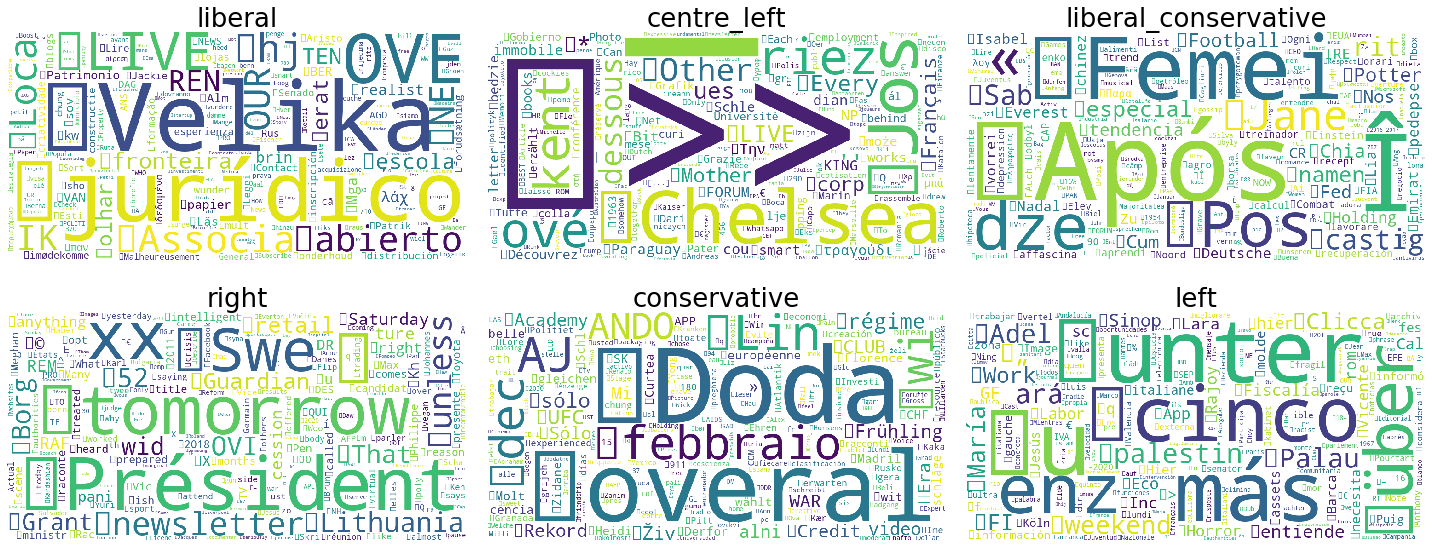

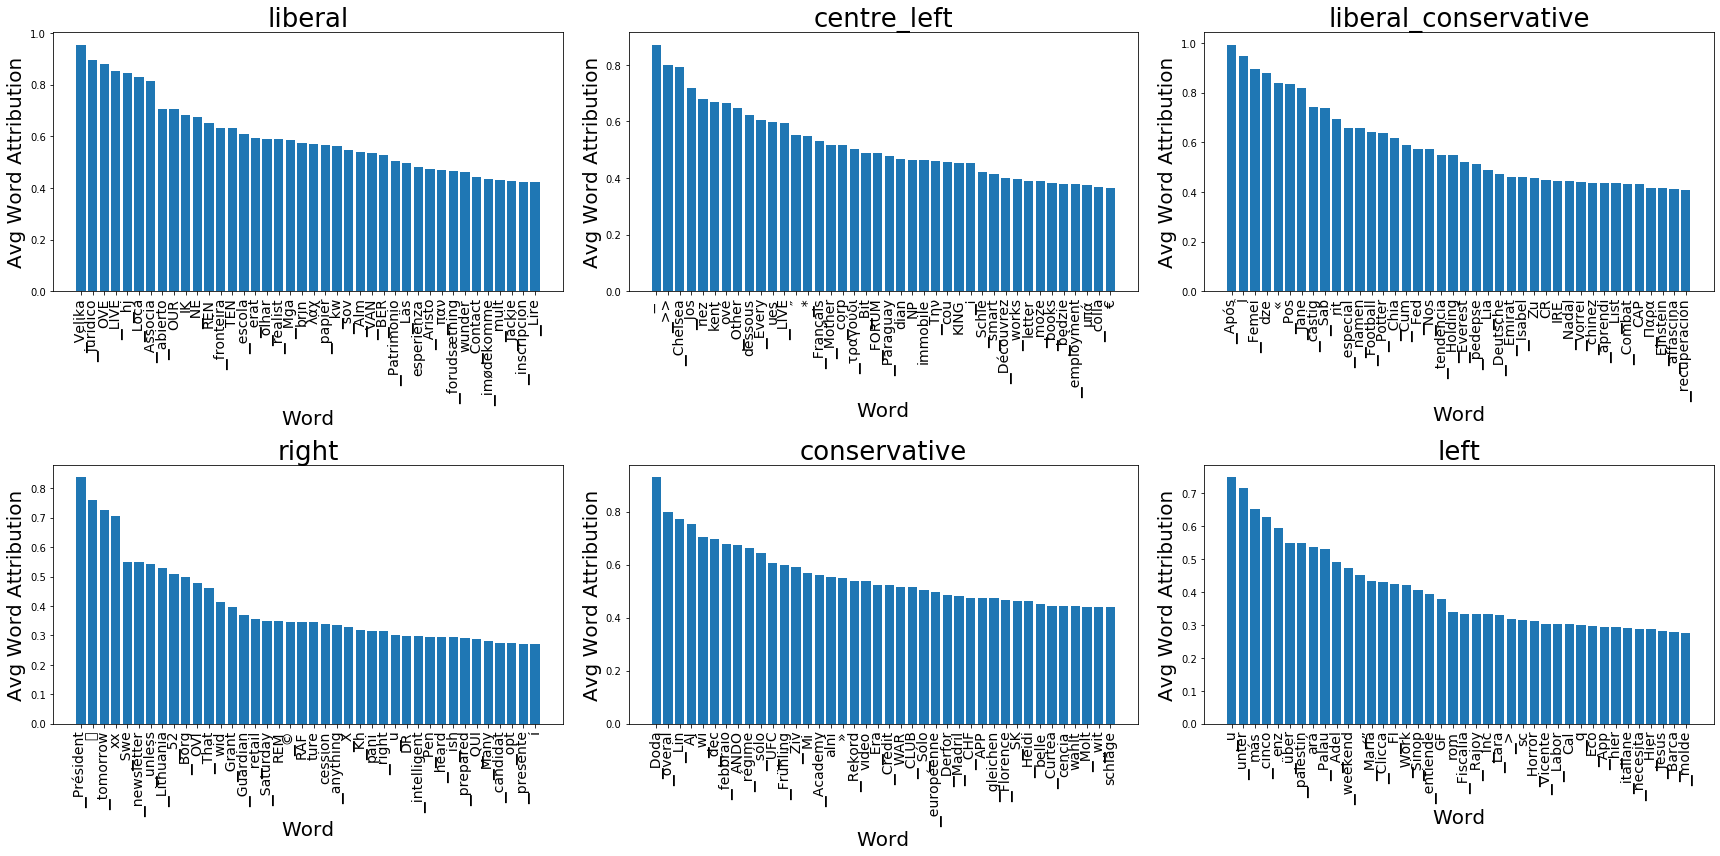

In [33]:
expl_file = r'C:\Users\virgi\Desktop\PhD\Bellomo\test\transformers_interpret\XLM\test_bias\classes_explained_test_no_bias.pickle'
model = 'XLM'
test_type = 'test_bias'
cleaned = False
analyze_explanations(expl_file, model, test_type, cleaned)


#### Cleaning class-explanations:
- in this new attempt i trying to see the semantyc-full words that receive higher attention by removing multilingual stop words and punctuations

In [ ]:
import stopwordsiso as stopwords # contain multilingual stopwords for all eu countries + uk
import string
# list of punctuations
punct = [x for x in string.punctuation]
# list of eu stopwords
eu_stop = list(stopwords.stopwords(["fi", "sv", "de","pt", "fr", "en", "hu", "el", "et", "sl", "hr", "es", "ga", "it", "tr", "mt", "lb", "nl"
, "ro", "da", "pl", "bg", "cs", "lv", "lt", "sk"])) 



#### mBERT test bias


In [ ]:

word_att_file = '/homenfs/l.bellomo1/new_attempt_classifier/explain/transformers_interpret/mBERT/test_no_bias/classes_dict_word_attention.pickle'
dict_word_attention_class = open(word_att_file, 'rb')
dict_word_attention_class = pickle.load(dict_word_attention_class)
cleaned = True
model = 'mBERT'
test_type = 'test_no_bias'
# create for each class a dict with words (that are not punctuations and stop words) as key and attention as values
cleaned_dict_word_attention_class = dict()

for _class in dict_word_attention_class:
    cleaned_dict_word_attention_class[_class] = dict()
    not_stop_class = list()
    class_words = list(dict_word_attention_class[_class].keys())
    for word in class_words:
        if (word.lower() not in eu_stop) and (word not in punct) and ('##' not in word):
            cleaned_dict_word_attention_class[_class][word] = dict_word_attention_class[_class][word]
plot_word_cloud(cleaned_dict_word_attention_class, model, test_type, cleaned)
bar_chart(cleaned_dict_word_attention_class, model, test_type, cleaned)